In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from scipy.special import expit, logit
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

2024-05-20 20:36:44.379707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')
train['BZ_GSM'] = train['BZ_GSM'].fillna(train['BZ_GSM'].mean())  # Naplní NaN hodnoty priemerom danej stĺpca
test['BZ_GSM'] = test['BZ_GSM'].fillna(test['BZ_GSM'].mean())  
features = ['time1', 'DST', 'DST+5', 'BZ_GSM', 'KP']
test = test[features]
train = train[features]
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])
predicators = ["DST", "BZ_GSM", "KP"]
y_col='DST+5'
valid_size = int(len(train) * 0.2)
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

y_train = train[y_col].values.copy()
X_train = train[predicators].values.copy()
y_val = valid[y_col].values.copy()
X_val = valid[predicators].values.copy()
y_test = test[y_col].values.copy()
X_test = test[predicators].values.copy()

In [3]:
n_input = 6  
n_features= len(X_train)  
b_size = 256  

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [4]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  896
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [5]:
inputs = Input(shape=(6,3))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2024-05-20 20:36:50.667788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 3)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 256)           135168    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7     

In [6]:
saved_model = "5h_dopredu200+BZ+KP.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [7]:
history = model.fit(train_generator, validation_data=val_generator, epochs=200, verbose=1, callbacks = callbacks_list)

Epoch 1/200
896/896 [==============================] - ETA: 0s - loss: 216.5898 - mae: 8.5731
Epoch 1: val_mae improved from inf to 8.79905, saving model to 5h_dopredu200+BZ+KP.hdf5
896/896 [==============================] - 64s 64ms/step - loss: 216.5898 - mae: 8.5731 - val_loss: 263.9133 - val_mae: 8.7990
Epoch 2/200
896/896 [==============================] - ETA: 0s - loss: 129.1533 - mae: 7.2059
Epoch 2: val_mae improved from 8.79905 to 8.69203, saving model to 5h_dopredu200+BZ+KP.hdf5
896/896 [==============================] - 55s 62ms/step - loss: 129.1533 - mae: 7.2059 - val_loss: 226.7019 - val_mae: 8.6920
Epoch 3/200
896/896 [==============================] - ETA: 0s - loss: 121.4408 - mae: 7.1297
Epoch 3: val_mae improved from 8.69203 to 8.57695, saving model to 5h_dopredu200+BZ+KP.hdf5
896/896 [==============================] - 55s 61ms/step - loss: 121.4408 - mae: 7.1297 - val_loss: 209.3314 - val_mae: 8.5770
Epoch 4/200
896/896 [==============================] - ETA: 0s - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



896/896 [==============================] - ETA: 0s - loss: 109.0199 - mae: 6.8780
Epoch 20: val_mae did not improve from 8.19941
896/896 [==============================] - 55s 62ms/step - loss: 109.0199 - mae: 6.8780 - val_loss: 187.9577 - val_mae: 8.3705
Epoch 21/200
896/896 [==============================] - ETA: 0s - loss: 107.9656 - mae: 6.8639
Epoch 21: val_mae did not improve from 8.19941
896/896 [==============================] - 55s 62ms/step - loss: 107.9656 - mae: 6.8639 - val_loss: 189.0096 - val_mae: 8.2832
Epoch 22/200
896/896 [==============================] - ETA: 0s - loss: 107.3299 - mae: 6.8335
Epoch 22: val_mae did not improve from 8.19941
896/896 [==============================] - 55s 62ms/step - loss: 107.3299 - mae: 6.8335 - val_loss: 211.3188 - val_mae: 8.7588
Epoch 23/200
896/896 [==============================] - ETA: 0s - loss: 107.2953 - mae: 6.8536
Epoch 23: val_mae did not improve from 8.19941
896/896 [==============================] - 56s 63ms/step - loss:

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



896/896 [==============================] - ETA: 0s - loss: 106.3229 - mae: 6.8233
Epoch 34: val_mae did not improve from 8.19941
896/896 [==============================] - 52s 58ms/step - loss: 106.3229 - mae: 6.8233 - val_loss: 191.1266 - val_mae: 8.3661
Epoch 35/200
896/896 [==============================] - ETA: 0s - loss: 105.2161 - mae: 6.8052
Epoch 35: val_mae did not improve from 8.19941
896/896 [==============================] - 56s 62ms/step - loss: 105.2161 - mae: 6.8052 - val_loss: 193.4988 - val_mae: 8.3888
Epoch 36/200
896/896 [==============================] - ETA: 0s - loss: 105.7612 - mae: 6.8240
Epoch 36: val_mae improved from 8.19941 to 8.13406, saving model to 5h_dopredu200+BZ+KP.hdf5
896/896 [==============================] - 57s 63ms/step - loss: 105.7612 - mae: 6.8240 - val_loss: 177.4151 - val_mae: 8.1341
Epoch 37/200
896/896 [==============================] - ETA: 0s - loss: 105.5524 - mae: 6.8076
Epoch 37: val_mae did not improve from 8.13406
896/896 [=========

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



895/896 [============================>.] - ETA: 0s - loss: 104.0564 - mae: 6.7850
Epoch 49: val_mae did not improve from 8.10317
896/896 [==============================] - 49s 54ms/step - loss: 103.9761 - mae: 6.7823 - val_loss: 206.9962 - val_mae: 8.6404
Epoch 50/200
896/896 [==============================] - ETA: 0s - loss: 103.6963 - mae: 6.7829
Epoch 50: val_mae did not improve from 8.10317
896/896 [==============================] - 49s 54ms/step - loss: 103.6963 - mae: 6.7829 - val_loss: 198.6344 - val_mae: 8.5738
Epoch 51/200
896/896 [==============================] - ETA: 0s - loss: 103.9700 - mae: 6.7799
Epoch 51: val_mae did not improve from 8.10317
896/896 [==============================] - 50s 55ms/step - loss: 103.9700 - mae: 6.7799 - val_loss: 216.2056 - val_mae: 8.7948
Epoch 52/200
896/896 [==============================] - ETA: 0s - loss: 103.9046 - mae: 6.7834
Epoch 52: val_mae did not improve from 8.10317
896/896 [==============================] - 49s 54ms/step - loss:

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



896/896 [==============================] - ETA: 0s - loss: 101.8664 - mae: 6.7394
Epoch 68: val_mae did not improve from 8.10317
896/896 [==============================] - 49s 55ms/step - loss: 101.8664 - mae: 6.7394 - val_loss: 196.0084 - val_mae: 8.5831
Epoch 69/200
896/896 [==============================] - ETA: 0s - loss: 101.8603 - mae: 6.7452
Epoch 69: val_mae did not improve from 8.10317
896/896 [==============================] - 48s 54ms/step - loss: 101.8603 - mae: 6.7452 - val_loss: 198.2364 - val_mae: 8.5837
Epoch 70/200
896/896 [==============================] - ETA: 0s - loss: 102.2821 - mae: 6.7587
Epoch 70: val_mae did not improve from 8.10317
896/896 [==============================] - 49s 55ms/step - loss: 102.2821 - mae: 6.7587 - val_loss: 207.5416 - val_mae: 8.7628
Epoch 71/200
895/896 [============================>.] - ETA: 0s - loss: 101.6481 - mae: 6.7406
Epoch 71: val_mae did not improve from 8.10317
896/896 [==============================] - 49s 55ms/step - loss:

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [8]:
model = keras.models.load_model('5h_dopredu200+BZ+KP.hdf5')

In [9]:
y_pred = model.predict(test_generator)

633/633 [==============================] - 14s 19ms/step


In [10]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test[:-6], y_pred.reshape(-1))
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 87.18916794032232


In [11]:
y_val_pred = model.predict(val_generator)

true_labels_val = np.where(y_val[n_input:] <= -20, 1, 0)  

def calculate_mcc(y_true, y_pred):
    return matthews_corrcoef(y_true, y_pred)

thresholds = np.arange(-10, -40, -0.1)
mcc_scores = []

for thresh in thresholds:
    predictions = np.where(y_val_pred <= thresh, 1, 0)
    mcc = calculate_mcc(true_labels_val, predictions)
    mcc_scores.append(mcc)

best_threshold_mcc = thresholds[np.argmax(mcc_scores)]
best_mcc = max(mcc_scores)

best_threshold_mcc_rounded = round(best_threshold_mcc, 1)
print(best_threshold_mcc_rounded)
y_pred2 = np.where(y_pred <= best_threshold_mcc_rounded, 1, 0)
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

224/224 [==============================] - 5s 20ms/step
-20.2
Confusion matrix: 
[[125343   4646]
 [ 10775  21266]]


In [12]:
print(classification_report(y_test2, y_pred2))


              precision    recall  f1-score   support

           0       0.92      0.96      0.94    129989
           1       0.82      0.66      0.73     32041

    accuracy                           0.90    162030
   macro avg       0.87      0.81      0.84    162030
weighted avg       0.90      0.90      0.90    162030



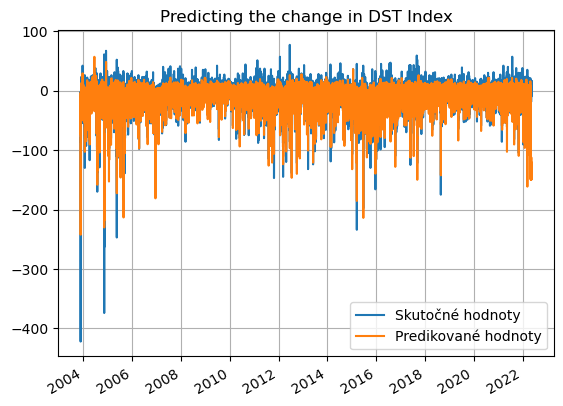

In [13]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [14]:
df.to_csv('5h_dopredu+200+BZ+KP.csv')

In [15]:
TN, FP, FN, TP = cm.ravel()
ACC = (TP + TN) / (TP + TN + FP + FN)
MCC = matthews_corrcoef(y_test2, y_pred2)
print("ACC={}".format(ACC))
print("MCC={}".format(MCC))

ACC=0.9048262667407271
MCC=0.6823974883379283
